In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import numpy as np
BASE_DIR = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
BASE_DIR

In [ ]:
label_names = ['Happy', 'Sad', 'Fear', 'Surprise', 'Neutral', 'Angry', 'Disgust']
labels = [0, 1, 2, 3, 4, 5, 6]
all_img_with_label = []
for i in range(len(label_names)):
    cur_label = labels[i]
    label_n = label_names[i]
    # Modify sub_folder_name to use different data set
    # /SFEW_aug/ takes about 1-2 hours for 5-fold training on a NVIDIA GeForce RTX 3090
    #                ...   2-3 hours for 10-fold training ...
    # /SFEW/ takes about 10-20 minutes for 5-fold training on a NVIDIA GeForce RTX 3090
    ## feel free to remove some samples to speed up the training

    sub_folder_name = "/SFEW/"
#     sub_folder_name = "/SFEW_aug/"

    # img_names is a list of img names e.g. HarryPotter.png
    img_names = os.listdir(BASE_DIR + sub_folder_name + label_n)
    img_names = list(filter(lambda x: x.endswith('.png'), img_names))
    
    # img_names_with_label is a list of tuple (img_address, label)
    img_names_with_label = [(BASE_DIR + sub_folder_name + label_n+ "/" + name, cur_label) for name in img_names]

    all_img_with_label.extend(img_names_with_label)
print(len(all_img_with_label))

In [5]:
norm_mean = [0.485, 0.456, 0.406]  # from ImageNet
norm_std = [0.229, 0.224, 0.225] # from ImageNet

# transform is input to the Dataset class
train_transform = transforms.Compose([
    transforms.Resize((256)),      
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

valid_transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

In [6]:
def get_vgg16(path_state_dict, device, use_pretrained_model=True):
    """
    Create a vgg16 model and update parameters with pretrained model if needed
    path_state_dict: path to the pretrained model
    
    pretrained model can be downloaded here: https://download.pytorch.org/models/vgg16-397923af.pth
    """
    
    if use_pretrained_model:
        if os.path.isfile(path_state_dict):
            model = models.vgg16()
            pretrained_state_dict = torch.load(path_state_dict)
            model.load_state_dict(pretrained_state_dict)
        else:
            model = models.vgg16(pretrained=True) # not exist, download it from onlne
    else:
        model = models.vgg16() 
    model.eval()
    model.to(device)
    
    return model

In [7]:
class FaceDatasetKFold(Dataset):
    '''
    This Dataset class is for K-Fold training
    '''
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        

    def __getitem__(self, index):
        path_img = self.X[index]
        label = self.Y[index]
        img = Image.open(path_img).convert('RGB') 

        if self.transform is not None:
            img = self.transform(img) # transform with the input transformer

        return img, label

    def __len__(self):
        return len(self.Y)


In [8]:
def train_kfold(model, X_train, y_train, X_val, y_val, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list,
                BATCH_SIZE, learning_rate, TOTAL_EPOCHS, lr_decay_step=1):
    
    # creat the data loader of train and validation datasets
    train_loader = DataLoader(FaceDatasetKFold(X_train,y_train, train_transform), BATCH_SIZE, shuffle = True)
    val_loader = DataLoader(FaceDatasetKFold(X_val, y_val, valid_transform), BATCH_SIZE, shuffle = True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    model.to(device)
    model.train()
    for epoch in range(TOTAL_EPOCHS):
        total_loss = 0
        total = 0
        correct = 0
        for i, (X, Y) in enumerate(train_loader):
            Y = torch.as_tensor(Y)
            X, Y = X.to(device), Y.to(device)
            
            y_pred = model(X)
            
            # backward
            optimizer.zero_grad()        
            loss = criterion(y_pred, Y)
            loss.backward()
            
            # update
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            total += predicted.size(0)
            correct += (predicted == Y).squeeze().cpu().sum().numpy()
            total_loss += loss.item()
       

        train_losses.append(total_loss)
        acc = 100 * correct / total
        train_acc.append(acc)
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%' % (epoch + 1, TOTAL_EPOCHS, total_loss, acc))
        train_loss_list.append(total_loss)
        train_acc_list.append(acc)

        # evaluate on the validation set in each epoch
        model.eval()
        with torch.no_grad():
            total_loss_val = 0
            correct_val = 0
            total_val = 0
            for _, (X, Y) in enumerate(val_loader):
                Y = torch.as_tensor(Y)
                X, Y = X.to(device), Y.to(device)
                y_val_pred = model(X)
                loss = criterion(y_val_pred, Y)
                
                # calculate loss 
                total_loss_val += loss.item()
                _, val_predicted = torch.max(y_val_pred, 1)
                total_val += val_predicted.size(0)
                correct_val += (val_predicted == Y).squeeze().cpu().sum().numpy()
            # calculate accuracy
            acc = 100 * correct_val / total_val
            val_acc.append(acc)
            val_losses.append(total_loss_val)
            print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
                    total_loss_val, correct_val, total_val, acc))
            valid_loss_list.append(total_loss_val)
            valid_acc_list.append(acc)
                
        model.train()
        scheduler.step()  # update learning rate in each epoch
        
        
    num = len(train_losses)
    # return average loss and accuracy over all epochs
    return model, sum(train_losses)/num, sum(val_losses)/num, sum(train_acc)/num, sum(val_acc)/num


In [ ]:
from sklearn.model_selection import KFold

def k_fold(k, data_X, data_Y, num_epochs = 10, learning_rate = 0.01, batch_size = 64, num_classes=7):
    '''
    Main function for the K-Fold training
    '''

    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum , valid_acc_sum = 0, 0
    # pretrained model is downloaded here: https://download.pytorch.org/models/vgg16-397923af.pth
    # please put the model in the same directory of the code file or change the path_state_dict accordingly
    path_state_dict = "vgg16-397923af.pth"  # path to the pretrained model
    model = get_vgg16(path_state_dict, device, True)

    # adjust models for the task
    num_ftrs = model.classifier._modules["6"].in_features
    model.classifier._modules["6"] = nn.Linear(num_ftrs, num_classes)
    
    # collect loss and accuracy of each epoch
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    kf = KFold(n_splits=k)
    for train_idx, test_idx in kf.split(data_X):
        # split into train/validation datasets
        X_train = [data_X[i] for i in train_idx]
        X_valid = [data_X[i] for i in test_idx]
        Y_train = [data_Y[i] for i in train_idx]
        Y_valid = [data_Y[i] for i in test_idx]

        # train for each split
        model, train_loss, val_loss, train_acc, val_acc = train_kfold(model, X_train, Y_train, X_valid, Y_valid, train_loss_list, val_loss_list, train_acc_list,
                                                                      val_acc_list, batch_size, learning_rate, num_epochs) 
       
        # collect loss and accuracy
        print('train_loss:{:.5f}, train_acc:{:.3f}%'.format(train_loss, train_acc))
        print('valid loss:{:.5f}, valid_acc:{:.3f}%\n'.format(val_loss, val_acc))
        
        train_loss_sum += train_loss
        valid_loss_sum += val_loss
        train_acc_sum += train_acc
        valid_acc_sum += val_acc
        
    print('\n', '#'*10,'Final result','#'*10)
    print('average train loss:{:.4f}, average train accuracy:{:.3f}%'.format(train_loss_sum/k, train_acc_sum/k))
    print('average valid loss:{:.4f}, average valid accuracy:{:.3f}%'.format(valid_loss_sum/k, valid_acc_sum/k))

    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list


def final_eval(model, data_test, BATCH_SIZE=32):
    '''
    Evaluate the final model on the reserved test set
    '''
    data_test_X = [x[0] for x in data_test]
    data_test_Y = [x[1] for x in data_test]
    test_loader = DataLoader(FaceDatasetKFold(data_test_X, data_test_Y, valid_transform), BATCH_SIZE, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    correct_val = 0
    total_val = 0
    for _, (X, Y) in enumerate(test_loader):
        Y = torch.as_tensor(Y)
        X, Y = X.to(device), Y.to(device)
        y_test_pred = model(X)
        # calculate loss of each batch
        loss = criterion(y_test_pred, Y)
        total_loss += loss.item()
        _, test_predicted = torch.max(y_test_pred, 1)
        total_val += test_predicted.size(0)
        correct_val += (test_predicted == Y).squeeze().cpu().sum().numpy()
    
    # calculat the accuracy
    acc = 100 * correct_val / total_val
    print('Final test loss:{:.4f}, test accuracy:{:.3f}%'.format(total_loss, acc))


random.shuffle(all_img_with_label)
# split into test (for final evaluation) and train (for K-Fold training)
split_idx = int(len(all_img_with_label) * 0.9)
train_data = all_img_with_label[:split_idx]
test_data = all_img_with_label[split_idx:] # use for final testing
train_X = [x[0] for x in train_data]
train_Y = [x[1] for x in train_data]

# K in K-fold
num_fold = 5

# collect loss and accuracy for analysis
model, train_loss_list, val_loss_list, train_acc_list, val_acc_list = k_fold(num_fold, train_X, train_Y)

# evaluate on the reserved test set
final_eval(model, test_data)

Epoch [1/10], Loss: 72.2795, Accuracy: 23.01 %
Validation set: Average loss: 18.0970, Accuracy: 176/608 (28.947%)

Epoch [2/10], Loss: 66.0646, Accuracy: 32.11 %
Validation set: Average loss: 16.7531, Accuracy: 221/608 (36.349%)

Epoch [3/10], Loss: 62.5843, Accuracy: 37.22 %
Validation set: Average loss: 16.5898, Accuracy: 219/608 (36.020%)

Epoch [4/10], Loss: 61.9312, Accuracy: 38.29 %
Validation set: Average loss: 16.5585, Accuracy: 230/608 (37.829%)

Epoch [5/10], Loss: 62.0742, Accuracy: 36.76 %
Validation set: Average loss: 16.7089, Accuracy: 228/608 (37.500%)

Epoch [6/10], Loss: 61.5789, Accuracy: 39.15 %
Validation set: Average loss: 16.6894, Accuracy: 221/608 (36.349%)

Epoch [7/10], Loss: 61.9466, Accuracy: 38.21 %
Validation set: Average loss: 16.6487, Accuracy: 225/608 (37.007%)

Epoch [8/10], Loss: 61.6815, Accuracy: 38.33 %
Validation set: Average loss: 16.7019, Accuracy: 223/608 (36.678%)

Epoch [9/10], Loss: 61.9289, Accuracy: 38.04 %
Validation set: Average loss: 16.

## Forllowing are results from my expriments

In [14]:
# vgg_pretrained; SFEW: 
#average train loss:10.9299, average train accuracy:50.355%
#average valid loss:2.9479, average valid accuracy:43.511%
#Final test loss:7.8848, test accuracy:35.294%

train_loss_list = [15.792727708816528,
 14.406745553016663,
 14.145501017570496,
 14.168780446052551,
 14.108584523200989,
 14.011586666107178,
 14.055561184883118,
 14.124471426010132,
 14.020232796669006,
 14.018179178237915,
 14.263363718986511,
 12.675822019577026,
 12.272962212562561,
 12.293944954872131,
 12.193059802055359,
 11.967047452926636,
 11.924076557159424,
 12.396933794021606,
 11.973890662193298,
 12.149425864219666,
 12.808509588241577,
 11.388141989707947,
 10.149605393409729,
 10.034838795661926,
 10.056020736694336,
 10.094451665878296,
 10.120994925498962,
 10.18886387348175,
 10.300177931785583,
 10.055035471916199,
 12.342697858810425,
 10.97193968296051,
 9.970897674560547,
 9.450231790542603,
 9.682849884033203,
 9.744766473770142,
 9.822770833969116,
 9.703530311584473,
 9.781924486160278,
 9.476978659629822,
 10.24408495426178,
 8.323547303676605,
 7.081593155860901,
 6.889223992824554,
 6.702515959739685,
 6.593709707260132,
 6.711145341396332,
 6.647551536560059,
 7.051214814186096,
 7.143771588802338]

val_loss_list = [3.944937229156494,
 3.8594647645950317,
 3.8473628759384155,
 3.8556631803512573,
 3.839029550552368,
 3.8570942878723145,
 3.856199860572815,
 3.844833016395569,
 3.837465524673462,
 3.8528711795806885,
 3.337603449821472,
 3.1907875537872314,
 3.200701117515564,
 3.2779884338378906,
 3.227188467979431,
 3.2513623237609863,
 3.2120426893234253,
 3.1948134899139404,
 3.2217600345611572,
 3.205243706703186,
 3.155152916908264,
 2.802562713623047,
 2.9044452905654907,
 2.865825653076172,
 2.8367961645126343,
 2.8496471643447876,
 2.809377670288086,
 2.820875883102417,
 2.8758562803268433,
 2.8227293491363525,
 2.957035541534424,
 2.733282446861267,
 2.669346332550049,
 2.6322864294052124,
 2.6614867448806763,
 2.679492235183716,
 2.6430609226226807,
 2.664337158203125,
 2.6920887231826782,
 2.7319146394729614,
 2.5098694562911987,
 2.11612069606781,
 2.0661612153053284,
 2.010943293571472,
 1.978673279285431,
 1.9867231845855713,
 1.9803926944732666,
 2.0597150325775146,
 1.9679480195045471,
 1.9983651638031006]

train_acc_list = [18.350515463917525,
 28.65979381443299,
 31.54639175257732,
 30.721649484536083,
 33.1958762886598,
 35.05154639175258,
 33.1958762886598,
 30.721649484536083,
 32.577319587628864,
 32.78350515463917,
 30.309278350515463,
 41.44329896907217,
 45.97938144329897,
 41.855670103092784,
 44.123711340206185,
 43.09278350515464,
 47.628865979381445,
 44.5360824742268,
 46.597938144329895,
 42.06185567010309,
 39.300411522633745,
 48.148148148148145,
 55.55555555555556,
 56.584362139917694,
 53.7037037037037,
 55.96707818930041,
 55.349794238683124,
 56.37860082304527,
 53.08641975308642,
 56.17283950617284,
 43.00411522633745,
 55.55555555555556,
 58.43621399176955,
 61.31687242798354,
 60.08230452674897,
 57.61316872427984,
 57.818930041152264,
 60.288065843621396,
 60.08230452674897,
 59.465020576131685,
 53.7037037037037,
 64.40329218106996,
 68.51851851851852,
 69.34156378600824,
 72.42798353909465,
 70.16460905349794,
 69.34156378600824,
 71.81069958847736,
 69.95884773662551,
 69.75308641975309]

val_acc_list = [15.573770491803279,
 17.21311475409836,
 18.852459016393443,
 20.491803278688526,
 18.0327868852459,
 18.852459016393443,
 20.491803278688526,
 18.852459016393443,
 18.852459016393443,
 20.491803278688526,
 38.52459016393443,
 34.42622950819672,
 36.885245901639344,
 35.24590163934426,
 36.0655737704918,
 36.885245901639344,
 38.52459016393443,
 36.0655737704918,
 38.52459016393443,
 36.885245901639344,
 38.84297520661157,
 47.107438016528924,
 47.107438016528924,
 47.93388429752066,
 48.760330578512395,
 48.760330578512395,
 50.413223140495866,
 46.28099173553719,
 47.107438016528924,
 45.45454545454545,
 52.892561983471076,
 51.239669421487605,
 49.586776859504134,
 52.06611570247934,
 52.06611570247934,
 55.37190082644628,
 51.239669421487605,
 56.19834710743802,
 52.06611570247934,
 51.239669421487605,
 53.71900826446281,
 61.15702479338843,
 66.11570247933884,
 63.63636363636363,
 66.11570247933884,
 65.2892561983471,
 65.2892561983471,
 62.8099173553719,
 61.98347107438016,
 61.98347107438016]

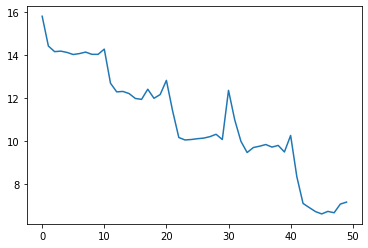

In [15]:
plt.plot(train_loss_list)

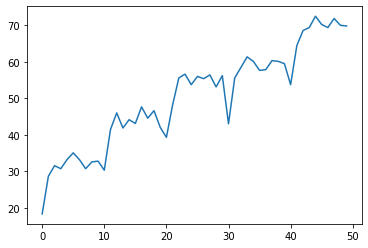

In [16]:
plt.plot(train_acc_list)

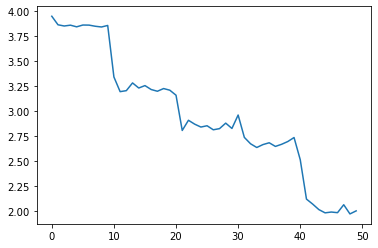

In [17]:
plt.plot(val_loss_list)

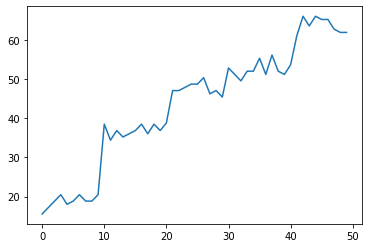

In [18]:
plt.plot(val_acc_list)

In [45]:
# vgg_pretrained SFEW_aug
#average train loss:30.6216, average train accuracy:64.281%
#average valid loss:9.1373, average valid accuracy:58.354%
#Final test loss:9.9374, test accuracy:62.963%
train_loss_list = [58.70769476890564,
 51.46284246444702,
 47.82883930206299,
 47.5754679441452,
 47.17361271381378,
 47.73088526725769,
 47.78810453414917,
 47.51694691181183,
 47.03286254405975,
 47.398884296417236,
 50.90996432304382,
 41.3602774143219,
 36.05554378032684,
 34.32733190059662,
 34.28302651643753,
 34.630319118499756,
 34.24573874473572,
 33.674834847450256,
 34.630685567855835,
 34.78359854221344,
 44.95373177528381,
 33.45112198591232,
 26.875006318092346,
 25.623674988746643,
 25.48819875717163,
 25.986081540584564,
 24.934991359710693,
 25.762194335460663,
 25.70674043893814,
 25.53892010450363,
 37.53798723220825,
 25.402614772319794,
 18.91532301902771,
 17.455293893814087,
 18.08401297032833,
 18.488543540239334,
 17.988769322633743,
 18.220583647489548,
 17.705639719963074,
 17.741472601890564,
 33.002254128456116,
 24.863299787044525,
 16.428222000598907,
 15.505624771118164,
 15.797194302082062,
 14.291078448295593,
 14.63837879896164,
 15.393370240926743,
 15.11254370212555,
 15.068385601043701]

train_acc_list = [22.067901234567902,
 36.26543209876543,
 43.98148148148148,
 44.70164609053498,
 44.34156378600823,
 43.26131687242798,
 42.6440329218107,
 43.82716049382716,
 44.23868312757202,
 43.26131687242798,
 37.86008230452675,
 50.51440329218107,
 57.97325102880659,
 60.18518518518518,
 59.36213991769547,
 59.053497942386834,
 61.21399176954733,
 60.699588477366255,
 60.13374485596708,
 59.5679012345679,
 45.781893004115226,
 61.26543209876543,
 69.23868312757202,
 70.21604938271605,
 70.98765432098766,
 71.2448559670782,
 71.81069958847736,
 71.2448559670782,
 72.53086419753086,
 71.81069958847736,
 55.041152263374485,
 71.3477366255144,
 78.7551440329218,
 81.27572016460906,
 80.45267489711934,
 79.3724279835391,
 79.88683127572017,
 79.57818930041152,
 80.8127572016461,
 80.24691358024691,
 60.54526748971193,
 71.75925925925925,
 81.27572016460906,
 83.23045267489712,
 82.76748971193416,
 83.79629629629629,
 84.20781893004116,
 82.56172839506173,
 82.61316872427983,
 83.23045267489712]

val_loss_list = [14.150576114654541,
 13.564491271972656,
 13.456322073936462,
 13.192540049552917,
 13.472410559654236,
 13.445147514343262,
 13.342238187789917,
 13.396925568580627,
 13.29326593875885,
 13.361033916473389,
 12.51355504989624,
 10.704571604728699,
 10.412897109985352,
 10.595083951950073,
 10.46378231048584,
 10.45218813419342,
 10.477293848991394,
 10.623436450958252,
 10.615206837654114,
 10.70687198638916,
 12.030461549758911,
 9.002683758735657,
 8.537544906139374,
 8.348273694515228,
 8.497478365898132,
 8.545518398284912,
 8.390075981616974,
 8.688833832740784,
 8.429777204990387,
 8.534334599971771,
 8.926484644412994,
 7.039600312709808,
 6.85112190246582,
 6.816971123218536,
 6.68498420715332,
 6.732560336589813,
 6.7993956208229065,
 6.7742738127708435,
 6.848745822906494,
 6.725071609020233,
 10.339910864830017,
 5.324344277381897,
 5.070175528526306,
 5.008991211652756,
 4.7691077291965485,
 4.9589574337005615,
 4.977604448795319,
 4.981126546859741,
 4.943642944097519,
 5.048804134130478]

val_acc_list = [31.275720164609055,
 34.97942386831276,
 37.242798353909464,
 38.065843621399175,
 36.41975308641975,
 36.008230452674894,
 36.62551440329218,
 38.27160493827161,
 38.065843621399175,
 36.83127572016461,
 41.97530864197531,
 50.41152263374486,
 53.90946502057613,
 52.26337448559671,
 51.23456790123457,
 51.440329218106996,
 53.49794238683128,
 51.64609053497942,
 53.29218106995885,
 52.05761316872428,
 44.03292181069959,
 59.053497942386834,
 63.16872427983539,
 60.08230452674897,
 61.72839506172839,
 61.31687242798354,
 62.34567901234568,
 60.90534979423868,
 63.78600823045267,
 62.34567901234568,
 56.37860082304527,
 68.93004115226337,
 69.1358024691358,
 70.37037037037037,
 70.37037037037037,
 68.51851851851852,
 69.1358024691358,
 70.78189300411523,
 69.34156378600824,
 70.78189300411523,
 50.617283950617285,
 77.77777777777777,
 79.42386831275721,
 78.18930041152264,
 79.21810699588477,
 77.98353909465021,
 78.39506172839506,
 80.45267489711934,
 79.21810699588477,
 78.39506172839506]

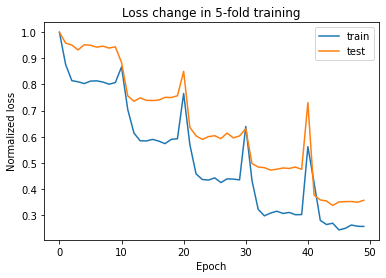

In [58]:
plt.plot([x / max(train_loss_list) for x in train_loss_list], label="train")
plt.plot([ x /  max(val_loss_list) for x in val_loss_list], label="test")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Normalized loss')
plt.title('Loss change in 5-fold training')
plt.savefig('loss_change_vgg.png')

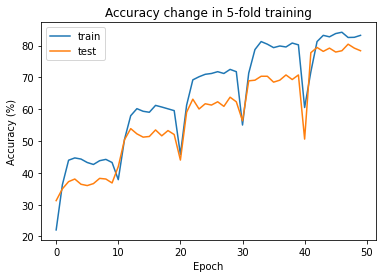

In [57]:
plt.plot(train_acc_list, label="train")
plt.plot(val_acc_list, label="test")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title("Accuracy change in 5-fold training")
plt.legend()
plt.savefig('acc_change_vgg.png')

In [30]:
# vgg_pretrained SFEW_aug 10-fold
# average train loss:24.8963, average train accuracy:74.916%
# average valid loss:3.3094, average valid accuracy:70.214%
# Final test loss:7.9863, test accuracy:71.111%
train_loss_list = [64.64453792572021,
 54.47862529754639,
 48.12110877037048,
 47.590962290763855,
 47.57997417449951,
 47.09629249572754,
 46.74212837219238,
 47.33828938007355,
 47.165114879608154,
 47.1590074300766,
 53.88023602962494,
 47.406606554985046,
 37.23684847354889,
 37.37263226509094,
 35.90863877534866,
 36.51985824108124,
 36.7448650598526,
 36.0710563659668,
 36.354785323143005,
 36.464249432086945,
 47.19301211833954,
 35.39003765583038,
 26.81249749660492,
 26.54090651869774,
 26.23687171936035,
 26.30605012178421,
 26.323961317539215,
 26.550229251384735,
 26.231987059116364,
 26.030191242694855,
 36.296980142593384,
 24.403915375471115,
 16.577558785676956,
 15.342951327562332,
 14.897197768092155,
 15.186713591217995,
 15.397863775491714,
 15.545474797487259,
 15.54437404870987,
 15.732410877943039,
 49.71740761399269,
 57.91448438167572,
 50.94187390804291,
 49.76769411563873,
 49.28257644176483,
 49.911155700683594,
 49.3106507062912,
 50.21230959892273,
 49.30844056606293,
 49.48341619968414,
 45.78533977270126,
 26.93612051010132,
 19.26625356078148,
 18.40937030315399,
 17.953095108270645,
 18.132673501968384,
 18.613435834646225,
 18.533628821372986,
 18.26651805639267,
 17.709254562854767,
 29.920483201742172,
 19.872082948684692,
 13.176439046859741,
 12.464475020766258,
 12.164739161729813,
 12.475279107689857,
 12.159128695726395,
 12.395971834659576,
 12.035309128463268,
 11.741020657122135,
 21.346158742904663,
 16.578581362962723,
 8.67435796558857,
 8.08049139380455,
 8.141130048781633,
 7.616657488048077,
 8.224664531648159,
 7.996134899556637,
 7.9533665627241135,
 7.84567616134882,
 19.084353268146515,
 13.275079224258661,
 7.402102380990982,
 6.895154230296612,
 7.050183676183224,
 6.9488535374403,
 6.815459409728646,
 6.97000502794981,
 6.844771519303322,
 7.075968354940414,
 12.399783089756966,
 7.985428594052792,
 4.031486224383116,
 4.161850925534964,
 4.194136817008257,
 4.261918656527996,
 4.466126121580601,
 4.600562859326601,
 4.612905144691467,
 3.8202673569321632]

train_acc_list = [27.023319615912207,
 40.51211705532693,
 47.73662551440329,
 49.15409236396891,
 49.15409236396891,
 49.565614997713766,
 51.0745313214449,
 49.794238683127574,
 50.57155921353452,
 49.97713763145862,
 42.43255601280293,
 50.84590763603109,
 62.322816643804295,
 63.648834019204386,
 63.60310928212163,
 63.8774577046182,
 64.60905349794238,
 63.648834019204386,
 62.78006401463192,
 63.83173296753544,
 50.617283950617285,
 64.38042981252858,
 72.8395061728395,
 73.84545038866027,
 73.61682670324646,
 73.2053040695016,
 74.30269775948788,
 73.43392775491542,
 74.80566986739827,
 73.7997256515775,
 62.55144032921811,
 75.35436671239141,
 84.27069044352994,
 85.13946044810243,
 84.77366255144032,
 85.59670781893004,
 85.36808413351623,
 84.59076360310928,
 84.27069044352994,
 84.2249657064472,
 47.64517604023777,
 38.27160493827161,
 47.9652491998171,
 50.297210791037955,
 50.617283950617285,
 49.61133973479652,
 50.70873342478281,
 49.10836762688614,
 50.114311842706904,
 49.74851394604481,
 53.63511659807956,
 72.19935985368085,
 81.43575674439872,
 82.8989483310471,
 82.94467306812986,
 82.71604938271605,
 82.35025148605395,
 81.84727937814358,
 82.07590306355739,
 82.80749885688158,
 67.99268404206676,
 81.43575674439872,
 88.11156835848193,
 88.1572930955647,
 88.98033836305441,
 88.93461362597165,
 89.43758573388203,
 88.3859167809785,
 89.25468678555099,
 89.62048468221307,
 79.56104252400549,
 84.77366255144032,
 91.95244627343392,
 93.09556470050298,
 92.36396890717879,
 94.01005944215821,
 92.2267946959305,
 92.63831732967536,
 92.63831732967536,
 93.14128943758574,
 81.61865569272976,
 88.24874256973023,
 93.59853680841336,
 94.23868312757202,
 93.73571101966164,
 94.14723365340649,
 94.19295839048925,
 93.64426154549611,
 93.50708733424783,
 93.55281207133059,
 87.334247828075,
 92.40969364426155,
 96.61636945587563,
 96.66209419295839,
 95.65614997713763,
 96.15912208504801,
 95.51897576588935,
 95.74759945130316,
 95.7018747142204,
 96.43347050754458]


val_loss_list = [6.737553954124451,
 5.763308644294739,
 5.858329772949219,
 5.720004558563232,
 5.654504776000977,
 5.650342702865601,
 5.76311457157135,
 5.662457227706909,
 5.744079113006592,
 5.697599768638611,
 7.314474701881409,
 4.95984160900116,
 4.720581293106079,
 4.748293995857239,
 4.644210875034332,
 4.642330169677734,
 4.784551739692688,
 4.546040415763855,
 4.8015056848526,
 4.703226447105408,
 5.6018582582473755,
 4.035625636577606,
 3.994936525821686,
 3.8863497972488403,
 3.927567720413208,
 3.905125617980957,
 3.7669953107833862,
 3.9404529333114624,
 3.791694939136505,
 4.0326879024505615,
 4.9260629415512085,
 2.8345075845718384,
 2.684904158115387,
 2.834701359272003,
 2.836739242076874,
 2.8297680616378784,
 2.877260684967041,
 2.709183394908905,
 2.738559663295746,
 2.6832308173179626,
 7.243762254714966,
 5.935714960098267,
 5.809312343597412,
 5.794841408729553,
 5.8888479471206665,
 5.990525484085083,
 5.8176902532577515,
 5.856170892715454,
 5.772342085838318,
 5.91109311580658,
 6.011061191558838,
 2.9678163528442383,
 2.697187304496765,
 2.920897603034973,
 2.802875816822052,
 2.841921865940094,
 2.8066550493240356,
 2.647761642932892,
 2.6991047859191895,
 2.7165393829345703,
 3.938667356967926,
 2.187880516052246,
 2.144759088754654,
 2.1915335059165955,
 2.1796945929527283,
 2.11492520570755,
 2.006394386291504,
 2.2538651823997498,
 2.1044790148735046,
 2.051152229309082,
 3.4062177538871765,
 1.4229212403297424,
 1.4070731699466705,
 1.4867146909236908,
 1.4157719910144806,
 1.3623179495334625,
 1.262639045715332,
 1.3369094729423523,
 1.4620666801929474,
 1.4203650653362274,
 3.159062922000885,
 0.9224148690700531,
 0.9838859736919403,
 0.9526384174823761,
 1.0543752014636993,
 0.9546994268894196,
 0.9627585709095001,
 1.0169304311275482,
 0.9495458453893661,
 1.081896886229515,
 1.824895441532135,
 0.867175966501236,
 0.7827390283346176,
 0.8999218940734863,
 0.8227324560284615,
 0.8919836282730103,
 0.86700339615345,
 0.8192309662699699,
 0.868597686290741,
 1.0157734751701355]

val_acc_list = [40.32921810699588,
 51.440329218106996,
 46.09053497942387,
 52.26337448559671,
 48.97119341563786,
 48.148148148148145,
 49.382716049382715,
 49.794238683127574,
 46.50205761316872,
 50.205761316872426,
 32.92181069958848,
 55.96707818930041,
 55.96707818930041,
 55.1440329218107,
 55.55555555555556,
 59.67078189300412,
 57.20164609053498,
 57.61316872427984,
 55.55555555555556,
 55.1440329218107,
 46.50205761316872,
 61.31687242798354,
 60.49382716049383,
 64.19753086419753,
 62.13991769547325,
 62.13991769547325,
 63.78600823045267,
 62.55144032921811,
 63.78600823045267,
 60.49382716049383,
 55.96707818930041,
 72.01646090534979,
 72.01646090534979,
 73.25102880658436,
 70.37037037037037,
 74.48559670781893,
 72.8395061728395,
 73.66255144032922,
 75.7201646090535,
 74.48559670781893,
 34.15637860082305,
 51.02880658436214,
 48.97119341563786,
 50.205761316872426,
 47.73662551440329,
 47.325102880658434,
 50.205761316872426,
 53.08641975308642,
 49.794238683127574,
 46.09053497942387,
 44.03292181069959,
 72.42798353909465,
 74.07407407407408,
 71.19341563786008,
 74.07407407407408,
 70.37037037037037,
 74.48559670781893,
 72.8395061728395,
 76.13168724279835,
 75.30864197530865,
 65.4320987654321,
 80.24691358024691,
 80.24691358024691,
 79.83539094650206,
 80.24691358024691,
 83.53909465020575,
 82.3045267489712,
 81.48148148148148,
 81.48148148148148,
 80.24691358024691,
 67.90123456790124,
 88.47736625514403,
 87.65432098765432,
 88.88888888888889,
 89.30041152263375,
 87.24279835390946,
 90.94650205761317,
 88.47736625514403,
 86.83127572016461,
 88.47736625514403,
 72.42798353909465,
 93.00411522633745,
 92.5925925925926,
 93.82716049382717,
 92.18106995884774,
 92.18106995884774,
 93.4156378600823,
 91.35802469135803,
 94.23868312757202,
 92.5925925925926,
 85.59670781893004,
 94.23868312757202,
 93.82716049382717,
 93.00411522633745,
 92.18106995884774,
 93.00411522633745,
 92.5925925925926,
 93.82716049382717,
 93.82716049382717,
 92.5925925925926]

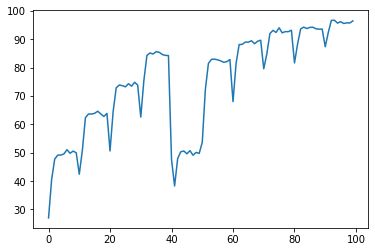

In [31]:
plt.plot(train_acc_list)

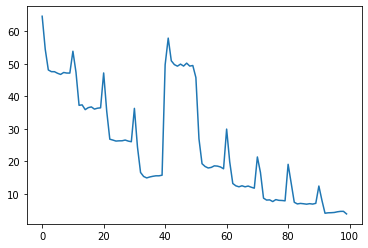

In [32]:
plt.plot(train_loss_list)

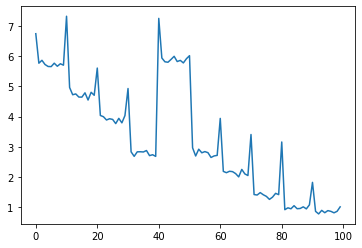

In [33]:
plt.plot(val_loss_list)

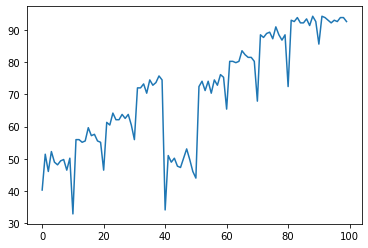

In [34]:
plt.plot(val_acc_list)